In [1]:
import pandas
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D
from torch.autograd import Variable
import torch.optim as optim
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
class Lin_Net(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, act_function):
        super(Lin_Net, self).__init__()
        self.act_function = act_function
        
        self.lin1 = nn.Linear(input_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)
        self.lin3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # act_funtion = F.sigmoid oder F.relu
        x = self.act_function(self.lin1(x))
        x = self.act_function(self.lin2(x))
        x = self.lin3(x)
        return x

In [3]:
class MyDataset(D.Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = torch.from_numpy(x_tensor)
        self.y = torch.from_numpy(y_tensor)
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

In [4]:
def make_data(dataset, features, batch_size, debug=False):
    datasets = []
    for file in dataset:
        datasets.append(pd.read_csv("../" + file))
    dataset = pd.concat(datasets, axis=0, ignore_index=True)
    
    target = dataset["affect"]
    dataset_full = dataset[["word_count", "upper_word_count", "ent_word_count", "h_count", "s_count", "a_count", "f_count", "cons_punct_count"]]
    dataset_nolex = dataset[["word_count", "upper_word_count", "ent_word_count", "cons_punct_count"]]
    dataset_lex = dataset[["h_count", "s_count", "a_count", "f_count"]]
    
    # make train and test sets
    if features == "full": 
        train_x, test_x, train_y, test_y = train_test_split(dataset_full, target, test_size=0.2)
    elif features == "nolex":
        train_x, test_x, train_y, test_y = train_test_split(dataset_nolex, target, test_size=0.2)
    elif features == "lex": 
        train_x, test_x, train_y, test_y = train_test_split(dataset_lex, target, test_size=0.2)

    # make data loaders
    train_data = MyDataset(train_x.to_numpy(), train_y.to_numpy())
    test_data = MyDataset(test_x.to_numpy(), test_y.to_numpy())
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size)
    test_loader = DataLoader(dataset=test_data, batch_size=1)
    
    if debug: 
        dataset_full = dataset_full.iloc[:10]
        target = target[:10]
        train_x, test_x, train_y, test_y = train_test_split(dataset_full, target, test_size=0.8)
        train_data = MyDataset(train_x.to_numpy(), train_y.to_numpy())
        train_loader = DataLoader(dataset=train_data, batch_size=batch_size)
        test_loader = DataLoader(dataset=train_data, batch_size=1)
    return train_loader, test_loader 

In [5]:
def log(summary, file):
    log = open(file, "a")
    log.write(summary)
    log.close()
    print(summary)

In [59]:
def train(train_loader, net, epochs, criterion, print_every, save_name, cuda, lr):
    open(save_name + "_train_log", "w").close()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.5)
    error_curve = []
    net.train()
    for epoch in range(epochs):
        for index, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.float(), targets.float()
            if cuda: 
                inputs = inputs.cuda()
                targets = targets.cuda()
                net = net.cuda()
            pred = net(inputs)    
            loss = criterion(pred, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if ((index) % print_every == 0):
                log("batch: {}/{} in epoch {}/{} \n... loss: {}\n".
                    format((index+1), len(train_loader), (epoch+1), epochs, loss.item()), 
                    save_name + "_train_log")
        # save network after every epoch
        torch.save(net.state_dict(), save_name + ".pt")  
        # after every epoch save the error
        error_curve.append([epoch, loss.item()])
    log("\n" + str(error_curve), save_name + "_train_log")
    return error_curve

def test(test_loader, net, criterion, print_every, save_name, cuda):
    open(save_name + "_test_log", "w").close()
    confusion = []
    net.eval()
    loss_sum, correct, correct2 = 0, 0, 0
    for index, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.float(), targets.float()
        if cuda: 
            inputs = inputs.cuda()
            targets = targets.cuda()
            net = net.cuda()
        pred = net(inputs)
        pred_class = round(pred.item())
        loss_sum += criterion(pred, targets).item()
        confusion.append([targets.item(), pred_class])
        
        # correct? 
        if pred_class == targets.item():
            correct += 1
        
        if ((index) % print_every == 0):
            log("batch: {}/{}\n... correct: {}\n".
                format((index+1), len(test_loader), correct), 
                save_name + "_test_log")
           
    # give end report
    log("average test loss: {}, relative correct: {}\n\nconfusion:\n{}".
        format((loss_sum / len(test_loader)), (correct / len(test_loader)),str(confusion)), 
        save_name + "_test_log")

In [8]:
# create variables 
print("creating variables")
emotion_dataset = ["emotion_classification_1_clean.csv", "emotion_classification_2_clean.csv", "emotion_classification_3_clean.csv", "emotion_classification_4_clean.csv", "emotion_classification_5_clean.csv", "emotion_classification_6_clean.csv", "emotion_classification_7_clean.csv", "emotion_classification_8_clean.csv"]
tweet_dataset = ["crowdflower_clean.csv", "emoint_clean.csv", "tec_clean.csv"]
act_function = torch.sigmoid
criterion = nn.MSELoss()
cuda = torch.cuda.is_available()

# create datasets
print("creating datasets")
train_loader_emotion_full, test_loader_emotion_full = make_data(emotion_dataset, "full", 25)
train_loader_emotion_nolex, test_loader_emotion_nolex = make_data(emotion_dataset, "nolex", 25)
train_loader_emotion_lex, test_loader_emotion_lex = make_data(emotion_dataset, "lex", 25)
train_loader_tweet_full, test_loader_tweet_full = make_data(tweet_dataset, "full", 25)
train_loader_tweet_nolex, test_loader_tweet_nolex = make_data(tweet_dataset, "nolex", 25)
train_loader_tweet_lex, test_loader_tweet_lex = make_data(tweet_dataset, "lex", 25)
train_loader_debug, test_loader_debug = make_data(emotion_dataset, "full", 25, True)
print("... done")

creating variables
creating datasets
... done


batch: 1/1 in epoch 1/10000 
... loss: 3.83048939704895

batch: 1/1 in epoch 2/10000 
... loss: 24.409971237182617

batch: 1/1 in epoch 3/10000 
... loss: 29.606203079223633

batch: 1/1 in epoch 4/10000 
... loss: 2.6951162815093994

batch: 1/1 in epoch 5/10000 
... loss: 0.6144814491271973

batch: 1/1 in epoch 6/10000 
... loss: 0.2604163885116577

batch: 1/1 in epoch 7/10000 
... loss: 0.27481818199157715

batch: 1/1 in epoch 8/10000 
... loss: 0.3143412470817566

batch: 1/1 in epoch 9/10000 
... loss: 0.31267011165618896

batch: 1/1 in epoch 10/10000 
... loss: 0.2893240451812744

batch: 1/1 in epoch 11/10000 
... loss: 0.26753827929496765

batch: 1/1 in epoch 12/10000 
... loss: 0.25531336665153503

batch: 1/1 in epoch 13/10000 
... loss: 0.25081127882003784

batch: 1/1 in epoch 14/10000 
... loss: 0.2500004470348358

batch: 1/1 in epoch 15/10000 
... loss: 0.2501829266548157

batch: 1/1 in epoch 16/10000 
... loss: 0.2503184676170349

batch: 1/1 in epoch 17/10000 
... loss: 0.2502

batch: 1/1 in epoch 163/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 164/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 165/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 166/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 167/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 168/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 169/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 170/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 171/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 172/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 173/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 174/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 175/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 176/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 177/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 178/10000 
... loss: 0.25000014901161194

batch: 1

batch: 1/1 in epoch 313/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 314/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 315/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 316/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 317/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 318/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 319/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 320/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 321/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 322/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 323/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 324/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 325/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 326/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 327/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 328/10000 
... loss: 0.25000014901161194

batch: 1

batch: 1/1 in epoch 489/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 490/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 491/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 492/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 493/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 494/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 495/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 496/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 497/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 498/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 499/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 500/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 501/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 502/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 503/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 504/10000 
... loss: 0.25000014901161194

batch: 1

batch: 1/1 in epoch 639/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 640/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 641/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 642/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 643/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 644/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 645/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 646/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 647/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 648/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 649/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 650/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 651/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 652/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 653/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 654/10000 
... loss: 0.25000014901161194

batch: 1

batch: 1/1 in epoch 777/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 778/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 779/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 780/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 781/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 782/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 783/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 784/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 785/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 786/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 787/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 788/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 789/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 790/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 791/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 792/10000 
... loss: 0.25000014901161194

batch: 1

batch: 1/1 in epoch 933/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 934/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 935/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 936/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 937/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 938/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 939/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 940/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 941/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 942/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 943/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 944/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 945/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 946/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 947/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 948/10000 
... loss: 0.25000014901161194

batch: 1

batch: 1/1 in epoch 1100/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1101/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1102/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1103/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1104/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1105/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1106/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1107/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1108/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1109/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1110/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1111/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1112/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1113/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1114/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1115/10000 
... loss: 0.25000014901

batch: 1/1 in epoch 1231/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1232/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1233/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1234/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1235/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1236/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1237/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1238/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1239/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1240/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1241/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1242/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1243/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1244/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1245/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1246/10000 
... loss: 0.25000014901

batch: 1/1 in epoch 1368/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1369/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1370/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1371/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1372/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1373/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1374/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1375/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1376/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1377/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1378/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1379/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1380/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1381/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1382/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1383/10000 
... loss: 0.25000014901

batch: 1/1 in epoch 1543/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1544/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1545/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1546/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1547/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1548/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1549/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1550/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1551/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1552/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1553/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1554/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1555/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1556/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1557/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1558/10000 
... loss: 0.25000014901

batch: 1/1 in epoch 1730/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1731/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1732/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1733/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1734/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1735/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1736/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1737/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1738/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1739/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1740/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1741/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1742/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1743/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1744/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1745/10000 
... loss: 0.25000014901

batch: 1/1 in epoch 1886/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1887/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1888/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1889/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1890/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1891/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1892/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1893/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1894/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1895/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1896/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1897/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1898/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1899/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1900/10000 
... loss: 0.25000014901161194

batch: 1/1 in epoch 1901/10000 
... loss: 0.25000014901

batch: 1/1 in epoch 2066/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2067/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2068/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2069/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2070/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2071/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2072/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2073/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2074/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2075/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2076/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2077/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2078/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2079/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2080/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2081/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 2229/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2230/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2231/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2232/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2233/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2234/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2235/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2236/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2237/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2238/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2239/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2240/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2241/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2242/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2243/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2244/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 2416/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2417/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2418/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2419/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2420/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2421/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2422/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2423/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2424/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2425/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2426/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2427/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2428/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2429/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2430/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2431/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 2571/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2572/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2573/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2574/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2575/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2576/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2577/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2578/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2579/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2580/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2581/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2582/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2583/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2584/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2585/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2586/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 2709/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2710/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2711/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2712/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2713/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2714/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2715/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2716/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2717/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2718/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2719/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2720/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2721/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2722/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2723/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2724/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 2874/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2875/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2876/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2877/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2878/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2879/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2880/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2881/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2882/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2883/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2884/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2885/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2886/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2887/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2888/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 2889/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 3012/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3013/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3014/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3015/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3016/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3017/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3018/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3019/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3020/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3021/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3022/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3023/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3024/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3025/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3026/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3027/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 3198/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3199/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3200/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3201/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3202/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3203/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3204/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3205/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3206/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3207/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3208/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3209/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3210/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3211/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3212/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3213/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 3361/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3362/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3363/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3364/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3365/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3366/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3367/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3368/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3369/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3370/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3371/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3372/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3373/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3374/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3375/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3376/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 3513/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3514/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3515/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3516/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3517/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3518/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3519/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3520/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3521/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3522/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3523/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3524/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3525/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3526/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3527/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3528/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 3694/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3695/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3696/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3697/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3698/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3699/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3700/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3701/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3702/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3703/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3704/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3705/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3706/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3707/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3708/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3709/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 3881/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3882/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3883/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3884/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3885/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3886/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3887/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3888/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3889/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3890/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3891/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3892/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3893/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3894/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3895/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 3896/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 4071/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4072/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4073/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4074/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4075/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4076/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4077/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4078/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4079/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4080/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4081/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4082/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4083/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4084/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4085/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4086/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 4248/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4249/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4250/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4251/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4252/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4253/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4254/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4255/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4256/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4257/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4258/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4259/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4260/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4261/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4262/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4263/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 4388/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4389/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4390/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4391/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4392/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4393/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4394/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4395/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4396/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4397/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4398/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4399/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4400/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4401/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4402/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4403/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 4559/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4560/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4561/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4562/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4563/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4564/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4565/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4566/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4567/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4568/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4569/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4570/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4571/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4572/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4573/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4574/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 4723/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4724/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4725/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4726/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4727/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4728/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4729/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4730/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4731/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4732/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4733/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4734/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4735/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4736/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4737/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4738/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 4898/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4899/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4900/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4901/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4902/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4903/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4904/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4905/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4906/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4907/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4908/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4909/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4910/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4911/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4912/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 4913/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 5043/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5044/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5045/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5046/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5047/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5048/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5049/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5050/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5051/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5052/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5053/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5054/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5055/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5056/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5057/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5058/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 5180/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5181/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5182/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5183/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5184/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5185/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5186/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5187/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5188/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5189/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5190/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5191/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5192/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5193/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5194/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5195/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 5350/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5351/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5352/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5353/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5354/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5355/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5356/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5357/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5358/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5359/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5360/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5361/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5362/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5363/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5364/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5365/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 5531/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5532/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5533/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5534/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5535/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5536/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5537/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5538/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5539/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5540/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5541/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5542/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5543/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5544/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5545/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5546/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 5692/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5693/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5694/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5695/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5696/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5697/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5698/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5699/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5700/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5701/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5702/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5703/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5704/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5705/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5706/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5707/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 5852/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5853/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5854/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5855/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5856/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5857/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5858/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5859/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5860/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5861/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5862/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5863/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5864/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5865/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5866/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 5867/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 6028/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6029/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6030/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6031/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6032/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6033/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6034/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6035/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6036/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6037/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6038/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6039/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6040/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6041/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6042/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6043/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 6203/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6204/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6205/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6206/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6207/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6208/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6209/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6210/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6211/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6212/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6213/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6214/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6215/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6216/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6217/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6218/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 6341/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6342/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6343/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6344/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6345/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6346/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6347/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6348/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6349/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6350/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6351/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6352/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6353/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6354/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6355/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6356/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 6516/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6517/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6518/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6519/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6520/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6521/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6522/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6523/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6524/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6525/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6526/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6527/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6528/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6529/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6530/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6531/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 6648/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6649/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6650/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6651/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6652/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6653/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6654/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6655/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6656/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6657/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6658/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6659/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6660/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6661/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6662/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6663/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 6822/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6823/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6824/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6825/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6826/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6827/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6828/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6829/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6830/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6831/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6832/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6833/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6834/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6835/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6836/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6837/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 6989/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6990/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6991/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6992/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6993/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6994/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6995/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6996/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6997/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6998/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 6999/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7000/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7001/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7002/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7003/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7004/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 7140/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7141/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7142/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7143/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7144/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7145/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7146/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7147/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7148/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7149/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7150/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7151/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7152/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7153/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7154/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7155/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 7330/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7331/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7332/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7333/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7334/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7335/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7336/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7337/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7338/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7339/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7340/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7341/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7342/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7343/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7344/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7345/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 7509/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7510/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7511/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7512/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7513/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7514/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7515/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7516/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7517/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7518/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7519/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7520/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7521/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7522/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7523/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7524/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 7682/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7683/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7684/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7685/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7686/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7687/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7688/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7689/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7690/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7691/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7692/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7693/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7694/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7695/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7696/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7697/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 7859/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7860/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7861/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7862/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7863/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7864/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7865/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7866/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7867/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7868/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7869/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7870/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7871/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7872/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7873/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7874/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 7992/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7993/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7994/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7995/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7996/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7997/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7998/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 7999/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8000/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8001/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8002/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8003/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8004/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8005/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8006/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8007/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 8157/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8158/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8159/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8160/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8161/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8162/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8163/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8164/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8165/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8166/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8167/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8168/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8169/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8170/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8171/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8172/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 8329/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8330/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8331/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8332/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8333/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8334/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8335/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8336/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8337/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8338/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8339/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8340/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8341/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8342/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8343/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8344/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 8488/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8489/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8490/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8491/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8492/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8493/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8494/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8495/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8496/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8497/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8498/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8499/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8500/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8501/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8502/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8503/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 8663/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8664/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8665/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8666/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8667/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8668/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8669/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8670/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8671/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8672/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8673/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8674/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8675/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8676/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8677/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8678/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 8842/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8843/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8844/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8845/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8846/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8847/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8848/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8849/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8850/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8851/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8852/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8853/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8854/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8855/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8856/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 8857/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 9011/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9012/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9013/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9014/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9015/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9016/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9017/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9018/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9019/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9020/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9021/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9022/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9023/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9024/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9025/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9026/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 9180/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9181/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9182/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9183/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9184/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9185/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9186/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9187/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9188/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9189/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9190/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9191/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9192/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9193/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9194/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9195/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 9337/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9338/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9339/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9340/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9341/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9342/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9343/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9344/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9345/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9346/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9347/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9348/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9349/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9350/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9351/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9352/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 9506/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9507/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9508/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9509/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9510/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9511/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9512/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9513/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9514/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9515/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9516/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9517/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9518/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9519/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9520/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9521/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 9672/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9673/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9674/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9675/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9676/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9677/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9678/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9679/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9680/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9681/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9682/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9683/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9684/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9685/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9686/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9687/10000 
... loss: 0.25000011920

batch: 1/1 in epoch 9829/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9830/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9831/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9832/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9833/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9834/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9835/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9836/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9837/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9838/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9839/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9840/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9841/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9842/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9843/10000 
... loss: 0.25000011920928955

batch: 1/1 in epoch 9844/10000 
... loss: 0.25000011920


[[0, 3.83048939704895], [1, 24.409971237182617], [2, 29.606203079223633], [3, 2.6951162815093994], [4, 0.6144814491271973], [5, 0.2604163885116577], [6, 0.27481818199157715], [7, 0.3143412470817566], [8, 0.31267011165618896], [9, 0.2893240451812744], [10, 0.26753827929496765], [11, 0.25531336665153503], [12, 0.25081127882003784], [13, 0.2500004470348358], [14, 0.2501829266548157], [15, 0.2503184676170349], [16, 0.25026971101760864], [17, 0.25015413761138916], [18, 0.2500627338886261], [19, 0.2500167489051819], [20, 0.2500019371509552], [21, 0.2500002384185791], [22, 0.2500012516975403], [23, 0.2500016391277313], [24, 0.2500012516975403], [25, 0.2500007152557373], [26, 0.25000035762786865], [27, 0.2500001788139343], [28, 0.25000014901161194], [29, 0.25000014901161194], [30, 0.25000014901161194], [31, 0.25000014901161194], [32, 0.25000014901161194], [33, 0.25000014901161194], [34, 0.25000014901161194], [35, 0.25000014901161194], [36, 0.25000014901161194], [37, 0.25000014901161194], [38,

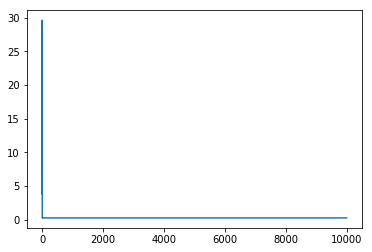

In [62]:
# debug set
net_full = Lin_Net(8, 1, 64, act_function)
plot = train(train_loader_debug, net_full, 10000, criterion, 1000, "../logs/debug_mse", cuda, 0.1)
plt.plot([item[0] for item in plot], [item[1] for item in plot])
test(test_loader_debug, net_full, criterion, 100, "../logs/debug_mse", cuda)

In [64]:
# create nets
print("creating nets")
print("-------- net_lin_emotion_full")
net_full = Lin_Net(8, 1, 64, act_function)
train(train_loader_emotion_full, net_full, 100, criterion, 5000, "../logs/net_lin_emotion_full", cuda, 0.1)
test(test_loader_emotion_full, net_full, criterion, 1000, "../logs/net_lin_emotion_full")


creating nets
-------- net_lin_emotion_full
batch: 1/11596 in epoch 1/100 
... loss: 2.126929998397827



/home/marcel/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([25])) that is different to the input size (torch.Size([25, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


batch: 5001/11596 in epoch 1/100 
... loss: 0.9482917785644531

batch: 10001/11596 in epoch 1/100 
... loss: 0.9050208330154419



/home/marcel/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


batch: 1/11596 in epoch 2/100 
... loss: 1.0512421131134033

batch: 5001/11596 in epoch 2/100 
... loss: 0.9476706385612488

batch: 10001/11596 in epoch 2/100 
... loss: 0.9045454263687134

batch: 1/11596 in epoch 3/100 
... loss: 1.0512477159500122

batch: 5001/11596 in epoch 3/100 
... loss: 0.9475566148757935

batch: 10001/11596 in epoch 3/100 
... loss: 0.9043766856193542

batch: 1/11596 in epoch 4/100 
... loss: 1.0512505769729614

batch: 5001/11596 in epoch 4/100 
... loss: 0.9475094676017761

batch: 10001/11596 in epoch 4/100 
... loss: 0.9042871594429016

batch: 1/11596 in epoch 5/100 
... loss: 1.0512512922286987

batch: 5001/11596 in epoch 5/100 
... loss: 0.9474838972091675

batch: 10001/11596 in epoch 5/100 
... loss: 0.9042299389839172

batch: 1/11596 in epoch 6/100 
... loss: 1.0512497425079346

batch: 5001/11596 in epoch 6/100 
... loss: 0.9474680423736572

batch: 10001/11596 in epoch 6/100 
... loss: 0.9041885733604431

batch: 1/11596 in epoch 7/100 
... loss: 1.0512450

KeyboardInterrupt: 

In [ ]:
print("-------- net_lin_emotion_nolex")
net_half = Lin_Net(4, 1, 64, act_function)
train(train_loader_emotion_nolex, net_half, 100, criterion, 5000, "../logs/net_lin_emotion_nolex", cuda, 0.1)
test(test_loader_emotion_nolex, net_half, criterion, 1000, "../logs/net_lin_emotion_nolex")
print("-------- net_lin_emotion_lex")
net_half = Lin_Net(4, 1, 64, act_function)
train(train_loader_emotion_lex, net_half, 100, criterion, 5000, "../logs/net_lin_emotion_lex", cuda, 0.1)
test(test_loader_emotion_lex, net_half, criterion, 1000, "../logs/net_lin_emotion_lex")
print("-------- net_lin_emotion_full")
net_full = Lin_Net(8, 1, 64, act_function)
train(train_loader_tweet_full, net_full, 100, criterion, 5000, "../logs/net_tweet_full", cuda, 0.1)
test(test_loader_tweet_full, net_full, criterion, 1000, "../logs/net_lin_tweet_full")
print("-------- net_lin_tweet_nolex")
net_half = Lin_Net(4, 1, 64, act_function)
train(train_loader_tweet_nolex, net_half, 100, criterion, 5000, "../logs/net_tweet_nolex", cuda, 0.1)
test(test_loader_tweet_nolex, net_half, criterion, 1000, "../logs/net_lin_tweet_nolex")
print("-------- net_lin_tweet_lex")
net_half = Lin_Net(4, 1, 64, act_function)
train(train_loader_tweet_lex, net_half, 100, criterion, 5000, "../logs/net_tweet_lex", cuda, 0.1)
test(test_loader_tweet_lex, net_half, criterion, 1000, "../logs/net_lin_tweet_lex")